In [1]:
# Mounting drive

from google.colab import drive

drive.mount('/content/drive')

import os
os.chdir("/content/drive/Shareddrives/InformationRetrieval_2022/project/inputs")

Mounted at /content/drive


# Import libraries

In [2]:
import json
import csv
import pandas as pd
import numpy as np
import re
import datetime
from numpy import linalg as la
from sklearn import preprocessing

In [3]:
import nltk
nltk.download('stopwords')

from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import itertools
import math
import numpy as np
import collections
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

# Function definitions

### Part 1 implementations

In [5]:
def clean(text):
    # transform to lowercase
    cleanText = text.lower()

    # removing the urls from tweeet, starts with https
    cleanText = re.sub('https?:\/\/.*[\r\n]*', '', cleanText, flags=re.MULTILINE)

    # removing nonalphanumeric
    cleanText = re.sub(r'[\W]+', ' ', cleanText)
    cleanText = re.sub(r'[\_]+', '', cleanText)
    
    return cleanText
 

In [6]:
def build_terms(text):

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    text = clean(text)

    # Tokenize the text to get a list of terms
    text =  text.split()

    # Eliminate the stopwords 
    text = [word for word in text if word not in stop_words]  

    # Stemming (keeping the root of the words)
    text = [stemmer.stem(word) for word in text] 
    
    return text

In [7]:
def create_mapping(filename, key, value, verbose=True):
  
  # Read the csv file
  mapping_df = pd.read_csv(filename, header=None, sep='\s', index_col=False)

  # Change column names 
  mapping_df.columns = [key, value]

  # Transform the pandas DataFrame to a dictionary {doc_id: tweet_id}
  mapping = dict()

  for idx, row in mapping_df.iterrows():
    mapping[row[key]] = row[value]

  if verbose:
    print('The length of the mapping is: ', len(mapping_df))
    print('Example of structure: ({} : {})'.format(list(mapping.keys())[0], list(mapping.values())[0]))

  return mapping

### Part 2 implementations

In [8]:
def create_index_tfidf(doc_to_tweet, tweets, num_documents):
    """
    Implement the inverted index and compute tf, df and idf
    
    Arguments:
    doc_to_tweet -- dictionary to pass from doc_id to tweet_it
    tweets -- collection of tweets
    num_documents -- total number of tweets
    
    Returns:
    index - the inverted index as a Python dictionary: {term: list of documents and positions}
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the collection
    idf = defaultdict(float)

    # Remember, tweets contain {tweet_id: {tweet info}}

    for doc_id, tweet_id in doc_to_tweet.items():  

        terms = tweets[tweet_id]['text']

        current_doc_index = {}

        for position, term in enumerate(terms): # iterate through tweet terms
            try:
                current_doc_index[term][1].append(position)  
            except:
                current_doc_index[term] = [doc_id, array('I',[position])]

        # Compute normalized term frequencies and df weights
        norm = 0

        for term, posting in current_doc_index.items(): # posting ==> [current_doc, [list of positions]] for each term
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        for term, posting in current_doc_index.items():
            tf[term].append(np.round(len(posting[1])/norm,4)) # append the tf for current term
            df[term] += 1 #increment the document frequency of current term

        # Merge the current page index with the main index
        for term_doc, posting in current_doc_index.items():
            index[term_doc].append(posting)

        # Compute IDF 
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return index, tf, df, idf


In [9]:
def rank_documents(query, tweets, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    query -- list of query terms
    tweets -- list of tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    
    Returns:
    List of ranked documents, List of corresponding scores
    """

    # doc_vectors[k] = (k,[0]*len(terms))
    doc_vectors = defaultdict(lambda: [0] * len(query)) 
    query_vector = [0] * len(query)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(query)  # term frequency for the query terms
    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(query):  #termIndex is the index of the term in the query
        if term not in index:
            # do not have into account terms that do not appear in query
            continue 

        # Compute tf*idf (normalize TF as done with documents)
        query_vector[termIndex]= query_terms_count[term]/query_norm * idf[term] 

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
         
            if doc in tweets:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term] 

    
    # Compute the score of each doc (cosine similarity with query vector)
    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True) #sort by descending order
    
    result_docs = [x[1] for x in doc_scores] # take doc_id
    result_scores = [x[0] for x in doc_scores] # take score

    return result_docs, result_scores

In [10]:
def get_hashtags(tweet):
    """ 
    Return the list of hastags (input) as a string (output)
    """
    return ' '.join(tweet['hashtags']).strip()

In [11]:
def tweet_Searcher(tweets, id):
    """ 
    Return the information of the tweet corresponding to the id as a string
    """
    tweet = tweets[id]
    return str("Text: " + str(tweet['text']) + "|" + "Username: " + str(tweet["username"]) + "|" + "Date: "+ str(tweet["date"]) + "|" + get_hashtags(tweet) + "|" + "Likes: " +  str(tweet["likes"]) + "|" + "Retweets: "+ str(tweet["retweets"]) + "|" + "Url: " + tweet['url'])


In [12]:
def search_tf_idf(query, index, idf, tf, doc_to_tweet):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    query -- list of query terms
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    doc_to_tweet -- dictionary to pass from doc_id to tweet_it
    
    Returns:
    List of ranked documents, List of corresponding scores, 
    Ranked list of documents that contain any of the query terms
    """

    query = build_terms(query) #preprocessing

    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs = [posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass

    docs = list(docs)

    ranked_docs, rank_scores = rank_documents(query, docs, index, idf, tf)

    return_list=[]
    for doc_id in ranked_docs:
        return_list.append(tweet_Searcher(tweets, doc_to_tweet[doc_id]))

    return ranked_docs, rank_scores, return_list

In [13]:
def precision_at_k(doc_score, y_score, k=10): # binary relevance, predicted relevnace, k for a given query
    """
    Argument:
    doc_score -- ground truth (true relevance labels).
    y_score -- Predicted scores.
    k -- number of doc to consider.

    Return:
    precision @k -- float

    """
    order = np.argsort(y_score)[::-1] # ranking of the documents according to the predicted score
    doc_score = np.take(doc_score, order[:k]) # retrieve ground truth according to the ranking order)
    relevant = sum(doc_score) # number of relevant documents

    return float(relevant) / k # compute precision at k, which is the number of relevant



In [14]:
def avg_precision_at_k(doc_score, y_score, k=10):    
    '''
    Argument:
    doc_score -- Ground truth
    y_score -- Predicted scores
    k -- number of tweet to consider
    
    Return:
    average precision @k : float
    '''
    gtp = np.sum(doc_score[:k]) # total number of gt positives
    order = y_score.argsort()[::-1]
    doc_score = doc_score.take(order)  
 
    ## if all tweets are non-relevant
    if gtp==0:
        return 0

    prec_at_i = 0
    
    iters=k
    if k > len(doc_score):
        iters=len(doc_score)

    for i in range(iters):
        if doc_score[i] == 1: # only add the P@k when the doc is relevant
            prec_at_i += precision_at_k(doc_score, y_score, i+1) # compute P@k
    
    return prec_at_i/gtp # compute average

In [15]:
def map_at_k(search_res, k=10):
    '''
    Argument:
    search_res -- search results dataset containing:
        query_id -- query id.
        tweet_id -- tweet id.
        score -- relevance predicted through td-idf.
        ground_truth -- actual relevance of the tweet for the query (ground truth).
    
    Return:
    mean average precision @k -- float
    '''
    
    avp = []
    for q in search_res["query_id"].unique(): #loop over all query id

         # select data for current query
        curr_data = search_res[search_res["query_id"] == q] 

        # append average precision for current query
        avp.append(avg_precision_at_k(np.array(curr_data["ground_truth"]), np.array(curr_data["score"]), k)) 
    return np.sum(avp)/len(avp) # return mean average precision

In [16]:
def mrr_at_k(search_res, k=10):
    '''
    Argument:
    doc_score -- Ground truth (true relevance labels).
    y_score -- Predicted scores.
    k : number of tweets to consider.
    
    Return:
    Mean Reciprocal Rank
    '''
    RRs = []
    
    for q in search_res["query_id"].unique():
        
        doc_score = np.array(search_res[search_res['query_id'] == q]["ground_truth"])
        y_score = np.array(search_res[search_res['query_id'] == q]["score"])
        
        order = y_score.argsort()[::-1]   # ranking of the documents according to the predicted score
        doc_score = doc_score.take(order)   # retrieve ground truth according to the ranking order)

        if np.sum(doc_score[:k])== str(0): # if there are not relevant doument return 0
            RRs.append(0)
        else:
            RRs.append(1/(doc_score.argmax()+1)) 

    return np.round(np.mean(RRs), 4)

In [17]:
def dcg_at_k(y_true, y_score,  k=10):
    '''
    Argument:
    y_true -- Ground truth (true relevance labels).
    y_score -- Predicted scores.
    k : number of tweets to consider.
    
    Return:
    DCG@k
    '''

    order = y_score.argsort()[::-1] 
    y_true = y_true.take(order)[:k]  

    gain = [] # Compute gain 
    for i in range(len(y_true)):
        gain.append((2**y_true[i])-1)
    
    discounts =[] # Compute denominator
    for i in range(len(y_true)):
        discounts.append(math.log2(i+2)) #we add +2 as the first position in array is 0 and first rank is 1
    
    division =[]
    for i in range(len(gain)):
        division.append(gain[i]/discounts[i])
        
    return np.sum(division) #return dcg@k

In [18]:
def ndcg_at_k(y_true, y_score, k=10):
    '''
    Argument:
    doc_score -- Ground truth (true relevance labels).
    y_score -- Predicted scores.
    k -- number of tweets to consider.
    
    Return:
    Normalized DCG@K
    '''

    dcg_max = dcg_at_k(y_true, y_true, k) # Ideal dcg order by y_true as we want the sort by relevance
    
    if not dcg_max:
        return 0
    
    return np.round((dcg_at_k(y_true, y_score, k))/dcg_max,4)  # return ndcg@k

### Part 3 implementations

#### Word2Vec + Cosine similarity

In [19]:
def embedding_w2v(terms, wv):
  ''' Generate the representation of a tweet as a unique vector of the same dimension of the words
  Average of vectors representing the words included in the tweet

  Arguments:
  terms -- terms of the tweet
  wv -- dictionary for {word: vector representation}

  Return:
  Embedding of the tweet (vector)
  '''
  embeddings = []

  for term in terms:
    if term in wv.vocab.keys():
      embeddings.append(wv.word_vec(term))
    
  return np.mean(embeddings, axis = 0)

In [20]:
def rank_Word2Vec(query, docs, doc_to_tweet, tweets):
  ''' Generate the ranking of the tweets according to a query using word2vec algorithm

  Argument:
  query -- query terms
  docs -- documents to rank
  doc_to_tweet -- dictionary to pass from doc_id to tweet_it
  tweets -- collection of tweets

  Return:
  List of ranked documents, List of corresponding scores
  '''

  # store all tweets in an iterable
  sentences = []
  for doc_id in docs:
    sentences.append(tweets[doc_to_tweet[doc_id]]['text'])

  # train model so that it learns the embeddings and the vocabulary
  model = Word2Vec(sentences)
  word_vectors = model.wv

  # create tweet2vec representation for all tweets
  docs2vec = dict()

  for doc_id in docs:
    tweet_id = doc_to_tweet[doc_id]
    docs2vec[doc_id] = embedding_w2v(tweets[tweet_id]['text'], wv=word_vectors)

  # get the query representation
  query_vec = embedding_w2v(query, wv=word_vectors)

  # compute cosine similarity between all documents and the query
  doc_scores = [[np.dot(curDocVec, query_vec), doc] for doc, curDocVec in docs2vec.items()]
  doc_scores.sort(reverse=True) #sort by descending order

  result_docs = [x[1] for x in doc_scores] # take doc_id
  result_scores = [x[0] for x in doc_scores] # take score

  return result_docs, result_scores

In [21]:
def search_word2vec(query, index, doc_to_tweet, tweets):
    """
    Perform the ranking of the results of a search based on: word2vec and applying cosine similarity

    Argument:
    query -- list of query terms
    index -- inverted index data structure
    
    Return: ranked_docs, rank_scores
    """
    query = build_terms(query) #preprocessing

    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs = [posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass
    
    docs = list(docs)

    ranked_docs, rank_scores = rank_Word2Vec(query, docs, doc_to_tweet, tweets)
    
    return ranked_docs, rank_scores

#### Our own score



In [ ]:

def rankTweetsOurs(terms, index, idf, tf, tweets,doc_to_tweet):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    doc_to_tweet -- dictionary that maps every doc_id with his tweet_id 

    Returns:
    sortedDocs --  List of ranked doc ids
    sortedScores --  List of ranked scores 
    sorted_list -- List of ranked tweets info
    """
    ranked_docs_full, ranked_scores_full, return_list_full = search_tf_idf(terms, index, idf, tf, doc_to_tweet)
    likes = []
    retweets = []
    hashtags = []

    ranked_docs = []
    ranked_scores = []
    return_list = []

    for tweet in tweets.keys():
      doc_id = [i for i in doc_to_tweet if doc_to_tweet[i]==tweet][0]
      ranked_docs.append(doc_id)
      try:
        idx = ranked_docs_full.index(doc_id)
        ranked_scores.append(ranked_scores_full[idx])
        return_list.append(return_list_full[idx])
      except:
        ranked_scores.append(0)
        return_list.append("")

    #we create 3 lists with the likes, retweets and hashtags for each tweet
    for doc in ranked_docs:
      likes.append(tweets[doc_to_tweet[doc]]["likes"])
      retweets.append(tweets[doc_to_tweet[doc]]["retweets"])
      hashtags.append(len(list(set(tweets[doc_to_tweet[doc]]["hashtags"]).intersection(set(terms.split(" ")))))*5)#we give a value of 5 if the tweet has hashtags that are in the query too

    # we compute our own score by assigning a weigth to each one of the previous 3 lists
    list_of_scores = []
    for i in range(0,len(likes)):
      list_of_scores.append(likes[i]*0.3 + retweets[i]*0.4 + hashtags[i]*0.3)

    list_of_scores_full = list_of_scores

    #we map the list of scores to 0 and 5, assigning a 0 to the lower value of the list and a 5 to the higher
    list_of_scores = np.array(list_of_scores).reshape(-1,1)
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 5))
    list_of_scores=list(scaler.fit_transform(list_of_scores))

    list_of_scores_norma = [float(i) for i in list_of_scores]

    list_of_scores = list_of_scores + ranked_scores


    #we sort all the 
    sorted_docs = [x for _, x in sorted(zip(list_of_scores, ranked_docs),reverse = True)]
    sorted_list = [x for _, x in sorted(zip(list_of_scores, return_list),reverse = True)]
    sorted_list_of_scores = [float(i) for i in sorted(list_of_scores,reverse=True)]

    

    #return rank punctuation and ids
    return sorted_docs, sorted_list_of_scores, sorted_list
    

#### BM25 score

In [ ]:
## BM25

def rankTweetsBM25(query, tweets, idf, doc_to_tweet, N, k1=1.2, b=0.75):
    """
    Perform the ranking of the results of a search based on BM25
    
    Argument:

    query -- list of query terms
    tweets -- diccionary of tweets
    idf -- inverted document frequencies (diccionary)
    k1 -- constant k1
    b -- constant b
    N -- total number of documents in the collection
    
    Returns:
    resultScores --  List of ranked scores of tweets
    resultTweets --  List of ranked tweet ids
    """

    query = build_terms(query) #preprocessing

    # Lave computation
    Lave = np.mean([len(tweet['text']) for id, tweet in tweets.items()])

    RSV =  dict()

    for tweet_id in tweets.keys():  

        doc_id = [i for i in doc_to_tweet if doc_to_tweet[i]==tweet_id][0]

        terms = tweets[tweet_id]['text'] # terms of the tweets

        Ld = len(terms) # document length
        
        # get tweet terms that are in the query
        query_terms = [t for t in terms if t in query] 

        # get raw term frequency of each query term appearing in the tweet
        raw_tf = collections.Counter(query_terms) 

        # Compute RSV score for the document by iterating through tweet terms IN the query
        RSV[doc_id] = 0
        for term in query_terms:
         
          numerador = (k1 + 1) * raw_tf[term]

          denominador = k1*((1-b) + b*(Ld/Lave)) + raw_tf[term]
  
          RSV[doc_id] += np.round(idf[term] * (numerador / denominador), 4)

    # Compute the score of each doc (cosine similarity with query vector)
    doc_scores = [[score, doc] for doc, score in RSV.items()]
    doc_scores.sort(reverse=True) #sort by descending order
    
    result_docs = [x[1] for x in doc_scores] # take doc_id
    result_scores = [x[0] for x in doc_scores] # take score      

    # sort results by BM25 score
    #full_dict = dict(sorted(RSV.items(), key=lambda item: item[1],reverse= True))
    #return dict(itertools.islice(full_dict.items(), k))

    return result_docs, result_scores

# Solution implementation

In [22]:
# Build a dictionary {doc_id: tweet_id}

doc_to_tweet = create_mapping('tweet_document_ids_map.csv', key='doc_id', value='tweet_id')

The length of the mapping is:  4000
Example of structure: (doc_1 : 1575918182698979328)


In [23]:
# Read data from .json

data = pd.read_json('tw_hurricane_data.json', lines = True)

In [24]:
# Checking that all tweets are in english

data['lang'].value_counts()

en    4000
Name: lang, dtype: int64

In [25]:
# Analyze original data

data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,metadata,source,...,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status_id,quoted_status_id_str,quoted_status
0,2022-09-30 18:39:08+00:00,1575918182698979328,1575918182698979328,So this will keep spinning over us until 7 pm…...,False,"[0, 76]","{'hashtags': [{'text': 'HurricaneIan', 'indice...","{'media': [{'id': 1575918178261254162, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,False,0,0,False,False,0.0,en,NaN,NaN,NaN
1,2022-09-30 18:39:01+00:00,1575918151862304768,1575918151862304768,Our hearts go out to all those affected by #Hu...,False,"[0, 136]","{'hashtags': [{'text': 'HurricaneIan', 'indice...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://sproutsocial.com"" rel=""nofoll...",...,False,0,0,False,False,NaN,en,NaN,NaN,NaN
2,2022-09-30 18:38:58+00:00,1575918140839673873,1575918140839673856,Kissimmee neighborhood off of Michigan Ave. \n...,False,"[0, 58]","{'hashtags': [{'text': 'HurricaneIan', 'indice...","{'media': [{'id': 1575918121080311808, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,False,0,0,False,False,0.0,en,NaN,NaN,NaN
3,2022-09-30 18:38:57+00:00,1575918135009738752,1575918135009738752,I have this one tree in my backyard that scare...,False,"[0, 141]","{'hashtags': [{'text': 'scwx', 'indices': [122...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,False,0,0,False,False,NaN,en,NaN,NaN,NaN
4,2022-09-30 18:38:53+00:00,1575918119251419136,1575918119251419136,@AshleyRuizWx @Stephan89441722 @lilmizzheidi @...,False,"[127, 280]","{'hashtags': [{'text': 'HurricaneIan', 'indice...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,False,0,0,False,False,NaN,en,NaN,NaN,NaN


### Creating a dictionary of tweets ( part 1 )

In [26]:
# Init dictionary
tweets = dict()


for idx, row in data.iterrows():

  # Init dictionary for each tweet
  tweet = dict()
    
  tweet['text'] = build_terms(row['full_text'])   # Clean and format text

  tweet['username'] = row['user']['screen_name']

  tweet['date'] =  row['created_at'].strftime('%d/%m/%Y %H:%M:%S')  # Format date

  tweet['hashtags'] = [h['text'] for h in row['entities']['hashtags']]  # Store a list of hashtags

  tweet['likes'] = row['favorite_count']

  tweet['retweets'] = row['retweet_count']

  tweet['url'] = 'https://twitter.com/'+row['user']['screen_name']+'/status/'+str(row['id'])  # Construct the url

  # Add tweet to the dictionary
  tweets[row['id']] = tweet


### Checks ( part 1 )

In [27]:
print('The document doc_id: {} has tweet_id: {}\n'.format('doc_1', doc_to_tweet['doc_1']))
print('In the intial DataFrame we have tweet_id {} at position 0\n'.format(data.iloc[0]['id']))
print('The original full_text is: [{}]'.format(data.iloc[0]['full_text']))

The document doc_id: doc_1 has tweet_id: 1575918182698979328

In the intial DataFrame we have tweet_id 1575918182698979328 at position 0

The original full_text is: [So this will keep spinning over us until 7 pm…go away already. #HurricaneIan https://t.co/VROTxNS9rz]


In [28]:
# Tweet after formatting

tweets[1575918140839673873]

{'text': ['kissimme', 'neighborhood', 'michigan', 'ave', 'hurricaneian'],
 'username': 'CHeathWFTV',
 'date': '30/09/2022 18:38:58',
 'hashtags': ['HurricaneIan'],
 'likes': 0,
 'retweets': 0,
 'url': 'https://twitter.com/CHeathWFTV/status/1575918140839673873'}

### Indexing ( part 2 )

In [29]:
import time
start_time = time.time()

N = len(tweets)

# Create full inverted index (inverted index, term frequencies, document frequencies, IDF)
index,tf,df,idf = create_index_tfidf(doc_to_tweet, tweets, N)

print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 242.95 seconds


In [ ]:
## Query 1

query1 = "Hurricane Ian"
ranked_docs, ranked_scores, return_list = search_tf_idf(query1, index, idf, tf, doc_to_tweet)
top = 10

print("\n======================\nTop {} results out of {} for the searched query: {} \n".format(top, len(ranked_docs), query1))
for idx, d_id in enumerate(ranked_docs[:top]):
    print("doc_id = {} - tweet_id: {} - score: {}".format(d_id, doc_to_tweet[d_id], ranked_scores[idx]))
    print("\t", return_list[idx])
    print("\n")


Top 10 results out of 1042 for the searched query: Hurricane Ian 

doc_id = doc_640 - tweet_id: 1575910304159977472 - score: 2.2314227007232357
	 Text: ['hurrican', 'ian', 'hurricaneian']|Username: kadenfields8|Date: 30/09/2022 18:07:50|HurricaneIan|Likes: 2|Retweets: 0|Url: https://twitter.com/kadenfields8/status/1575910304159977472


doc_id = doc_634 - tweet_id: 1575910361298968576 - score: 2.2314227007232357
	 Text: ['hurrican', 'ian', 'ian', 'hurricaneian', 'hurricanian', 'huracan', 'huracanian', 'hurrican']|Username: cesarharamillo|Date: 30/09/2022 18:08:03|Ian HurricaneIan HurricanIan Huracan HuracanIan Hurricane|Likes: 1|Retweets: 0|Url: https://twitter.com/cesarharamillo/status/1575910361298968576


doc_id = doc_1963 - tweet_id: 1575885709734543360 - score: 2.2314227007232357
	 Text: ['latest', 'hurrican', 'ian']|Username: KPRC2|Date: 30/09/2022 16:30:06|hurricaneian ian severewx kprc2 click2houston sc florida|Likes: 0|Retweets: 0|Url: https://twitter.com/KPRC2/status/15758857

In [ ]:
## Query 2


query2 = "Covid Pandemic"
ranked_docs, ranked_scores, return_list = search_tf_idf(query2, index, idf, tf, doc_to_tweet)
top = 10

print("\n======================\nTop {} results out of {} for the searched query: {} \n".format(top, len(ranked_docs), query2))
for idx, d_id in enumerate(ranked_docs[:top]):
    print("doc_id = {} - tweet_id: {} - score: {}".format(d_id, doc_to_tweet[d_id], ranked_scores[idx]))
    print("\t", return_list[idx])
    print("\n")


Top 10 results out of 7 for the searched query: Covid Pandemic 

doc_id = doc_3088 - tweet_id: 1575868406603350017 - score: 12.160545944094801
	 Text: ['heartbreak', 'fl', 'one', 'last', 'trip', 'us', '2019', 'pandem', 'heartbreak', 'see', 'pray', 'safe', 'florida', 'hurricaneian']|Username: ALYNH77|Date: 30/09/2022 15:21:21|Florida HurricaneIan|Likes: 0|Retweets: 0|Url: https://twitter.com/ALYNH77/status/1575868406603350017


doc_id = doc_2796 - tweet_id: 1575871626540818432 - score: 8.293263506655457
	 Text: ['mentalhealth', 'matter', 'ever', 'especi', 'given', 'covid', 'hurricaneian', 'take', 'care', 'rememb', 'simpli', 'enough', 'depaulsmn']|Username: AMDPU22|Date: 30/09/2022 15:34:08|MentalHealth COVID HurricaneIan DePaulSMN|Likes: 0|Retweets: 0|Url: https://twitter.com/AMDPU22/status/1575871626540818432


doc_id = doc_1903 - tweet_id: 1575886977764728838 - score: 7.0465833039606744
	 Text: ['talk', 'hurrican', 'way', 'conspiraci', 'believ', 'right', 'talk', 'covid', 'spot', 'amp

In [ ]:
## Query 3

query3 = "House destroyed"
ranked_docs, ranked_scores, return_list = search_tf_idf(query3, index, idf, tf, doc_to_tweet)
top = 10

print("\n======================\nTop {} results out of {} for the searched query: {} \n".format(top, len(ranked_docs), query3))
for idx, d_id in enumerate(ranked_docs[:top]):
    print("doc_id = {} - tweet_id: {} - score: {}".format(d_id, doc_to_tweet[d_id], ranked_scores[idx]))
    print("\t", return_list[idx])
    print("\n")


Top 10 results out of 125 for the searched query: House destroyed 

doc_id = doc_836 - tweet_id: 1575908417062903810 - score: 7.278078975376553
	 Text: ['mobil', 'home', 'commun', 'destroy', 'hurricaneian']|Username: leonardkl|Date: 30/09/2022 18:00:20|HurricaneIan|Likes: 0|Retweets: 0|Url: https://twitter.com/leonardkl/status/1575908417062903810


doc_id = doc_1881 - tweet_id: 1575887548039036933 - score: 7.258603402176856
	 Text: ['matlacha', 'home', 'destroy', 'hurricaneian', 'neighbor', 'tell', 'man', 'live', 'got', 'time', 'hous', 'crumbl', 'nbc2']|Username: ClaireNBC2|Date: 30/09/2022 16:37:24|Matlacha HurricaneIan|Likes: 6|Retweets: 0|Url: https://twitter.com/ClaireNBC2/status/1575887548039036933


doc_id = doc_2217 - tweet_id: 1575880135609573376 - score: 6.151864607988231
	 Text: ['car', 'destroy', 'hurricaneian', 'flood', 'via', 'ig', 'gisringhausen']|Username: wrldrn|Date: 30/09/2022 16:07:57|cars hurricaneian|Likes: 0|Retweets: 0|Url: https://twitter.com/wrldrn/status/1575

In [ ]:
## Query 4

query4 = "I am very sad"
ranked_docs, ranked_scores, return_list = search_tf_idf(query4, index, idf, tf, doc_to_tweet)
top = 10

print("\n======================\nTop {} results out of {} for the searched query: {} \n".format(top, len(ranked_docs), query4))
for idx, d_id in enumerate(ranked_docs[:top]):
    print("doc_id = {} - tweet_id: {} - score: {}".format(d_id, doc_to_tweet[d_id], ranked_scores[idx]))
    print("\t", return_list[idx])
    print("\n")


Top 10 results out of 20 for the searched query: I am very sad 

doc_id = doc_229 - tweet_id: 1575915199256739841 - score: 14.035991445
	 Text: ['sad', 'pawleysisland', 'hurricaneian', 'southcarolina']|Username: southrnfoodjunk|Date: 30/09/2022 18:27:17|pawleysisland HurricaneIan southcarolina|Likes: 0|Retweets: 0|Url: https://twitter.com/southrnfoodjunk/status/1575915199256739841


doc_id = doc_1764 - tweet_id: 1575890386249486336 - score: 14.035991445
	 Text: ['sad', 'read', 'today', 'hurricaneian']|Username: kamontree|Date: 30/09/2022 16:48:41|hurricaneian|Likes: 0|Retweets: 0|Url: https://twitter.com/kamontree/status/1575890386249486336


doc_id = doc_492 - tweet_id: 1575912058365042688 - score: 9.926253149904001
	 Text: ['thefungi669', 'sad', 'good', 'track', 'record', 'trumpcrimefamili', 'letitiajam', 'hurricaneian']|Username: Gary_McRobb|Date: 30/09/2022 18:14:48|TrumpCrimeFamily letitiajames HurricaneIan|Likes: 2|Retweets: 2|Url: https://twitter.com/Gary_McRobb/status/15759120

In [ ]:
## Query 5

query5 = "My dog suffered"
ranked_docs, ranked_scores, return_list = search_tf_idf(query5, index, idf, tf, doc_to_tweet)
top = 10

print("\n======================\nTop {} results out of {} for the searched query: {} \n".format(top, len(ranked_docs), query5))
for idx, d_id in enumerate(ranked_docs[:top]):
    print("doc_id = {} - tweet_id: {} - score: {}".format(d_id, doc_to_tweet[d_id], ranked_scores[idx]))
    print("\t", return_list[idx])
    print("\n")


Top 10 results out of 32 for the searched query: My dog suffered 

doc_id = doc_1392 - tweet_id: 1575899951812341760 - score: 11.393918233510043
	 Text: ['brave', 'man', 'save', 'dog', 'drown', 'hurricaneian', 'floodwat', 'rescu', 'ian', 'hurricanian', 'dog', 'braveri', 'hero']|Username: LynnSchore|Date: 30/09/2022 17:26:41|HurricaneIan rescue Ian HurricanIan dogs bravery hero|Likes: 1|Retweets: 0|Url: https://twitter.com/LynnSchore/status/1575899951812341760


doc_id = doc_2537 - tweet_id: 1575875317918748679 - score: 10.543081127704832
	 Text: ['pray', 'suffer', 'hurrican', 'hurricaneian']|Username: Gaming2klife1|Date: 30/09/2022 15:48:48|HurricaneIan|Likes: 0|Retweets: 0|Url: https://twitter.com/Gaming2klife1/status/1575875317918748679


doc_id = doc_90 - tweet_id: 1575916894309138432 - score: 7.028017879728041
	 Text: ['help', 'church', 'suffer', 'great', 'loss', 'florida', 'carolina', 'pleas', 'go']|Username: ReseedingAmeric|Date: 30/09/2022 18:34:01|HurricaneIan BIMI reseedingam

### Evaluation ( part 2 )

#### Ex 1

In [ ]:
# baseline with 3 queries and the ground truth files for each query

search_results = pd.read_csv("evaluation_gt.csv")

In [ ]:
print_result = search_results["label"].unique()
print("The ground truth of our dataset is composed of {} Relevance Levels: {}".format(len(print_result), sorted(print_result)))

The ground truth of our dataset is composed of 2 Relevance Levels: [0, 1]


In [ ]:
# queries Ex1 definition
q1 = "Landfall in South Carolina"
q2 = "Help and recovery during the hurricane disaster"
q3 = "Floodings in South Carolina"

# create the dataframe with this 3 queries
queries = [q1,q2,q3]
queries_df = pd.DataFrame(columns = ["tweet_id", "query_id", "score"])
idxs = []

# get the tweets_id
d = search_results["doc"].values
for i in range(len(search_results["doc"])):
  idxs.append((d[i],doc_to_tweet[d[i]]))


In [ ]:
# To be able to differenciate queries on idxs during loop
aux_1 = idxs[0:10] + idxs[30:40]
aux_2 = idxs[10:20] + idxs[40:50]
aux_3 = idxs[20:30] + idxs[50:60]
idxs = []
idxs.append(aux_1)
idxs.append(aux_2)
idxs.append(aux_3)

In [ ]:
for i in range(len(queries)):
    ranked_docs, ranked_scores, return_list = search_tf_idf(queries[i], index, idf, tf, doc_to_tweet)
    for d_id, t_id in idxs[i]:
      try:
        queries_df = queries_df.append({"tweet_id": t_id, "query_id": int(i+1), "score": ranked_scores[ranked_docs.index(str(d_id))], "url": tweets[doc_to_tweet[d_id]]['url']}, ignore_index=True)
      except:
        queries_df = queries_df.append({"tweet_id": t_id, "query_id": int(i+1), "score": 0, "url": tweets[doc_to_tweet[d_id]]['url']}, ignore_index=True)

# we sort by score, respecting the query_id value
queries_df = queries_df.sort_values(by=['query_id','score'], ascending = [True, False])

queries_df.head()

,tweet_id,query_id,score,url
6,1575916977717141504,1,3.641145,https://twitter.com/willy_lowry/status/1575916...
4,1575911964555247616,1,3.371244,https://twitter.com/AVEnthusiastsCH/status/157...
9,1575916073223962652,1,2.820090,https://twitter.com/NBCPhiladelphia/status/157...
7,1575916807927795712,1,2.395052,https://twitter.com/Jason_Disharoon/status/157...
2,1575917983062380545,1,2.243561,https://twitter.com/EddieMcCoven/status/157591...


In [ ]:
queries_df = queries_df.astype({'query_id': 'int64'})

In [ ]:
# we take ground_truth from the evaluation_gt
ground_truth = search_results["label"].values
len(ground_truth)

60

In [ ]:
queries_df['ground_truth'] = ground_truth
queries_df.drop(columns=['url'], inplace=True)
queries_df.head()

,tweet_id,query_id,score,ground_truth
6,1575916977717141504,1,3.641145,1
4,1575911964555247616,1,3.371244,1
9,1575916073223962652,1,2.820090,1
7,1575916807927795712,1,2.395052,1
2,1575917983062380545,1,2.243561,1


In [ ]:
current_query = 1
current_query_res = queries_df[queries_df["query_id"] == current_query]

k = 5
print("==> Precision@{}: {}\n".format(k, precision_at_k(current_query_res["ground_truth"], current_query_res["score"], k)))
print("\nCheck on the dataset sorted by score:\n")

current_query_res.sort_values("score", ascending=False).head(k)

==> Precision@5: 1.0


Check on the dataset sorted by score:



,tweet_id,query_id,score,ground_truth
6,1575916977717141504,1,3.641145,1
4,1575911964555247616,1,3.371244,1
9,1575916073223962652,1,2.820090,1
7,1575916807927795712,1,2.395052,1
2,1575917983062380545,1,2.243561,1


In [ ]:
# Check for query 2

current_query = 2
current_query_res = queries_df[queries_df["query_id"] == current_query]

k = 5
print("==> Precision@{}: {}\n".format(k, precision_at_k(current_query_res["ground_truth"], current_query_res["score"], k)))
print("\nCheck on the dataset sorted by score:\n")

current_query_res.sort_values("score", ascending=False).head(k)

==> Precision@5: 1.0


Check on the dataset sorted by score:



,tweet_id,query_id,score,ground_truth
27,1575913215942590469,2,2.957361,1
22,1575914737749016577,2,2.516081,1
29,1575911925526896640,2,1.861978,1
24,1575914189071138818,2,1.236198,1
21,1575915964817760257,2,1.235798,1


In [ ]:
# Check for query 3

current_query = 3
current_query_res = queries_df[queries_df["query_id"] == current_query]

k = 5
print("==> Precision@{}: {}\n".format(k, precision_at_k(current_query_res["ground_truth"], current_query_res["score"], k)))
print("\nCheck on the dataset sorted by score:\n")

current_query_res.sort_values("score", ascending=False).head(k)

==> Precision@5: 0.0


Check on the dataset sorted by score:



,tweet_id,query_id,score,ground_truth
42,1575917156734320663,3,3.348685,0
44,1575916229910470656,3,2.929887,0
41,1575917165831589890,3,2.699228,0
49,1575917165831589890,3,2.699228,0
40,1575917717600681984,3,2.101680,0


In [ ]:
current_query = 1
current_query_res = queries_df[queries_df["query_id"] == current_query]
avg_precision_at_k(np.array(current_query_res["ground_truth"]), np.array(current_query_res["score"]), 20)

1.0

In [ ]:
# Check with average_precision_score of sklearn

from sklearn.metrics import average_precision_score
k = 20
average_precision_score(np.array(current_query_res["ground_truth"]), np.array(current_query_res["score"][:k]))

1.0000000000000002

In [ ]:
map_k = map_at_k(queries_df, 20)
map_k

0.6666666666666666

In [ ]:
mrr_k = mrr_at_k(queries_df)
mrr_k

1.0

In [ ]:
k=10
for current_query in range(1,len(queries)+1):
  current_query_res = queries_df[queries_df["query_id"] == current_query]
  labels = np.array(current_query_res["ground_truth"])
  scores = np.array(current_query_res["score"])
  ndcg_k = np.round(ndcg_at_k(labels, scores, k),4)
  print("The ndcg@{} for query with query_id = {}: {}".format(k+1,current_query,ndcg_k))

The ndcg@11 for query with query_id = 1: 1.0
The ndcg@11 for query with query_id = 2: 1.0
The ndcg@11 for query with query_id = 3: 0


#### Ex 2

In [ ]:
#create the dataframe with our 5 queries to be evaluated
queries = [query1, query2, query3, query4, query5]
queries_df = pd.DataFrame(columns = ["tweet_id", "query_id", "score", 'url'])
top = 10

for i in range(len(queries)):
    ranked_docs, ranked_scores, return_list = search_tf_idf(queries[i], index, idf, tf, doc_to_tweet)

    for idx, d_id in enumerate(ranked_docs[:top]):
        queries_df = queries_df.append({"tweet_id": doc_to_tweet[d_id], "query_id": str(i+1), "score": ranked_scores[idx], "url": tweets[doc_to_tweet[d_id]]['url']}, ignore_index=True)        
queries_df.head()

,tweet_id,query_id,score,url
0,1575910304159977472,1,2.231423,https://twitter.com/kadenfields8/status/157591...
1,1575910361298968576,1,2.231423,https://twitter.com/cesarharamillo/status/1575...
2,1575885709734543360,1,2.231423,https://twitter.com/KPRC2/status/1575885709734...
3,1575912020368449536,1,2.043265,https://twitter.com/TheMoreYouKnw/status/15759...
4,1575881799267295234,1,1.932302,https://twitter.com/neveragainFL/status/157588...


In [ ]:
ground_truth = [ 1,0,1,0,1,1,0,0,0,1,1,1,0,1,0,0,1,1,1,0,0,0,1,1,0,0,0,0,1,0,1,0,1,1,0,1,1,1,0,0,0,1,0,1,0,0,1]

In [ ]:
len(ground_truth)

47

In [ ]:
queries_df['ground_truth'] = ground_truth

In [ ]:
queries_df.drop(columns=['url'], inplace=True)

In [ ]:
queries_df = queries_df.astype({'query_id': 'int64'})

In [ ]:
queries_df.head()

,tweet_id,query_id,score,ground_truth
0,1575910304159977472,1,2.231423,1
1,1575910361298968576,1,2.231423,0
2,1575885709734543360,1,2.231423,1
3,1575912020368449536,1,2.043265,0
4,1575881799267295234,1,1.932302,1


In [ ]:
# Check for query 1

current_query = 1
current_query_res = queries_df[queries_df["query_id"] == current_query]

k = 5
print("==> Precision@{}: {}\n".format(k, precision_at_k(current_query_res["ground_truth"], current_query_res["score"], k)))
print("\nCheck on the dataset sorted by score:\n")

current_query_res.sort_values("score", ascending=False).head(k)

==> Precision@5: 0.4


Check on the dataset sorted by score:



,tweet_id,query_id,score,ground_truth
0,1575910304159977472,1,2.231423,1
1,1575910361298968576,1,2.231423,0
2,1575885709734543360,1,2.231423,1
3,1575912020368449536,1,2.043265,0
4,1575881799267295234,1,1.932302,1


In [ ]:
# Check for query 2

current_query = 2
current_query_res = queries_df[queries_df["query_id"] == current_query]

k = 5
print("==> Precision@{}: {}\n".format(k, precision_at_k(current_query_res["ground_truth"], current_query_res["score"], k)))
print("\nCheck on the dataset sorted by score:\n")

current_query_res.sort_values("score", ascending=False).head(k)

==> Precision@5: 0.6


Check on the dataset sorted by score:



,tweet_id,query_id,score,ground_truth
10,1575868406603350017,2,12.160546,1
11,1575871626540818432,2,8.293264,1
12,1575886977764728838,2,7.046583,0
13,1575871595716935680,2,6.373914,1
14,1575865182944894978,2,5.369395,0


In [ ]:
# Check for query 3

current_query = 3
current_query_res = queries_df[queries_df["query_id"] == current_query]

k = 5
print("==> Precision@{}: {}\n".format(k, precision_at_k(current_query_res["ground_truth"], current_query_res["score"], k)))
print("\nCheck on the dataset sorted by score:\n")

current_query_res.sort_values("score", ascending=False).head(k)

==> Precision@5: 0.4


Check on the dataset sorted by score:



,tweet_id,query_id,score,ground_truth
17,1575908417062903810,3,7.278079,1
18,1575887548039036933,3,7.258603,1
19,1575880135609573376,3,6.151865,0
20,1575876492076408832,3,5.964746,0
21,1575875350973730816,3,5.850843,0


In [ ]:
# Check for query 4

current_query = 4
current_query_res = queries_df[queries_df["query_id"] == current_query]

k = 5
print("==> Precision@{}: {}\n".format(k, precision_at_k(current_query_res["ground_truth"], current_query_res["score"], k)))
print("\nCheck on the dataset sorted by score:\n")

current_query_res.sort_values("score", ascending=False).head(k)

==> Precision@5: 0.4


Check on the dataset sorted by score:



,tweet_id,query_id,score,ground_truth
27,1575915199256739841,4,14.035991,0
28,1575890386249486336,4,14.035991,1
29,1575912058365042688,4,9.926253,0
30,1575875202445348864,4,9.926253,1
31,1575884604741128192,4,9.926253,0


In [ ]:
# Check for query 5

current_query = 5
current_query_res = queries_df[queries_df["query_id"] == current_query]

k = 5
print("==> Precision@{}: {}\n".format(k, precision_at_k(current_query_res["ground_truth"], current_query_res["score"], k)))
print("\nCheck on the dataset sorted by score:\n")

current_query_res.sort_values("score", ascending=False).head(k)

==> Precision@5: 0.2


Check on the dataset sorted by score:



,tweet_id,query_id,score,ground_truth
37,1575899951812341760,5,11.393918,1
38,1575875317918748679,5,10.543081,0
39,1575916894309138432,5,7.028018,0
40,1575875501352046593,5,6.840351,0
41,1575909904845402112,5,6.652336,1


In [ ]:
avg_precision_at_k(np.array(current_query_res["ground_truth"]), np.array(current_query_res["score"]), 8)

0.5873015873015873

In [ ]:
max_k = len(current_query_res["score"])
for k in range(max_k):
  print("Av Precision Score at k = {}/{}: ".format(k+1,max_k),end="")
  print(avg_precision_at_k(np.array(current_query_res["ground_truth"]), np.array(current_query_res["score"]), k+1))

Av Precision Score at k = 1/10: 1.0
Av Precision Score at k = 2/10: 1.0
Av Precision Score at k = 3/10: 1.0
Av Precision Score at k = 4/10: 1.0
Av Precision Score at k = 5/10: 0.5
Av Precision Score at k = 6/10: 0.6666666666666666
Av Precision Score at k = 7/10: 0.5873015873015873
Av Precision Score at k = 8/10: 0.5873015873015873
Av Precision Score at k = 9/10: 0.5873015873015873
Av Precision Score at k = 10/10: 0.5404761904761904


In [ ]:
# Check with average_precision_score of sklearn

from sklearn.metrics import average_precision_score
k = max_k
average_precision_score(np.array(current_query_res["ground_truth"]), np.array(current_query_res["score"][:k]))

0.5404761904761904

In [ ]:
map_k = map_at_k(queries_df, 20)
map_k

0.6548280423280423

In [ ]:
mrr_k = mrr_at_k(queries_df)
mrr_k

1.0

In [ ]:
k=10
for current_query in range(1,len(queries)+1):
  current_query_res = queries_df[queries_df["query_id"] == current_query]
  labels = np.array(current_query_res["ground_truth"])
  scores = np.array(current_query_res["score"])
  ndcg_k = np.round(ndcg_at_k(labels, scores, k),4)
  print("The ndcg@{} for query with query_id={}: {}".format(k,current_query,ndcg_k))

The ndcg@10 for query with query_id=1: 0.8406
The ndcg@10 for query with query_id=2: 0.9349
The ndcg@10 for query with query_id=3: 0.9059
The ndcg@10 for query with query_id=4: 0.8201
The ndcg@10 for query with query_id=5: 0.7724


In [ ]:
# Review of all evaluations techniques for all queries
k = 10
for i in range(5):
    current_query = i + 1
    current_query_res = queries_df[queries_df["query_id"] == current_query] 
    print("\n==> For Query {} Precision@{}: {}".format(current_query, k,
                                precision_at_k(current_query_res["ground_truth"], current_query_res["score"], k)))

    print("Average Precission@{} for query with q_id={}: {}".format(k,current_query,avg_precision_at_k(np.array(current_query_res["ground_truth"]), np.array(current_query_res["score"]), 150)))

    

    labels = np.array(current_query_res["ground_truth"])
    scores = np.array(current_query_res["score"])
    ndcg_k = np.round(ndcg_at_k(labels, scores, k),4)
    print("ndcg@{} for query with query_id={}: {}".format(k,current_query,ndcg_k))
    
print("\nMAP@{}: {}".format(k,map_at_k(queries_df, k)))

print("MRR@{}: {}".format(k,mrr_at_k(queries_df, k)))


==> For Query 1 Precision@10: 0.5
Average Precission@10 for query with q_id=1: 0.6809523809523809
ndcg@10 for query with query_id=1: 0.8406

==> For Query 2 Precision@10: 0.4
Average Precission@10 for query with q_id=2: 0.8303571428571428
ndcg@10 for query with query_id=2: 0.9349

==> For Query 3 Precision@10: 0.4
Average Precission@10 for query with q_id=3: 0.7678571428571428
ndcg@10 for query with query_id=3: 0.9059

==> For Query 4 Precision@10: 0.6
Average Precission@10 for query with q_id=4: 0.4544973544973545
ndcg@10 for query with query_id=4: 0.8201

==> For Query 5 Precision@10: 0.4
Average Precission@10 for query with q_id=5: 0.5404761904761904
ndcg@10 for query with query_id=5: 0.7724

MAP@10: 0.6548280423280423
MRR@10: 1.0


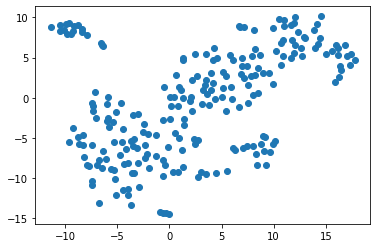

In [ ]:
clean_tweets = []
for doc_id, tweet_id in doc_to_tweet.items():
        terms = tweets[tweet_id]['text']
        clean_tweets.append(terms)

model = Word2Vec(clean_tweets, workers=4, min_count=50, window=10, sample=1e-3)


X = model.wv[model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()


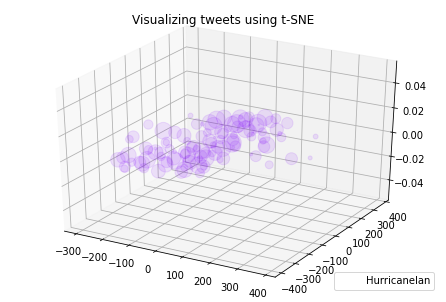

In [ ]:
model_wp = Word2Vec(clean_tweets, workers=4, min_count=50, window=10, sample=1e-3)


words_wp = []
embeddings_wp = []
for word in list(model_wp.wv.vocab):
    embeddings_wp.append(model_wp.wv[word])
    words_wp.append(word)
    
tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(embeddings_wp)

from mpl_toolkits.mplot3d import Axes3D


def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('Visualizing tweets using t-SNE', 'HurricaneIan', embeddings_wp_3d, a=0.1)

### Ranking (part 3)

#### BM25 score

In [ ]:
# try score
query = 'hurricane ian dog'

res_docs, res_scores = rankTweetsBM25(query, tweets, idf, doc_to_tweet, N=N)

"""for tweet_id, score in res.items():
  print("\n {} \t {}".format(tweet_id, score))
  print(str(tweets[tweet_id]['text']))"""


'for tweet_id, score in res.items():\n  print("\n {} \t {}".format(tweet_id, score))\n  print(str(tweets[tweet_id][\'text\']))'

#### Evaluation

##### Building the structure 

In [31]:
q1 = "Hurricane ian consequences"
q2 = "I am very sad" # change "Covid pandemic" because it has very few results
q3 = "Home destroyed" # --> less ambiguous
q4 = "Climate emergency"
q5 = "My dog suffered"

#create the dataframe with our 5 queries to be evaluated
queries = [q1, q2, q3, q4, q5]

In [ ]:
'''
queries_df = pd.DataFrame(columns = ["doc_id", "query_id", "score", 'url'])
top = 20

# Evaluate the queries with TF-IDF and store the results in the dataframe
for i in range(len(queries)):
    ranked_docs, ranked_scores, return_list = search_tf_idf(queries[i], index, idf, tf, doc_to_tweet)

    for idx, d_id in enumerate(ranked_docs[:20]):
        queries_df = queries_df.append({"doc_id": d_id, "query_id": i+1, "score": ranked_scores[idx], "url": tweets[doc_to_tweet[d_id]]['url']}, ignore_index=True)    

'''    

'\nqueries_df = pd.DataFrame(columns = ["doc_id", "query_id", "score", \'url\'])\ntop = 20\n\n# Evaluate the queries with TF-IDF and store the results in the dataframe\nfor i in range(len(queries)):\n    ranked_docs, ranked_scores, return_list = search_tf_idf(queries[i], index, idf, tf, doc_to_tweet)\n\n    for idx, d_id in enumerate(ranked_docs[:20]):\n        queries_df = queries_df.append({"doc_id": d_id, "query_id": i+1, "score": ranked_scores[idx], "url": tweets[doc_to_tweet[d_id]][\'url\']}, ignore_index=True)    \n\n'

In [ ]:
''' 
store results in a csv --> choose relevant ones

# queries_df[queries_df['query_id'] == 5].to_csv('query5_res.csv', index=False)
'''

" \nstore results in a csv --> choose relevant ones\n\n# queries_df[queries_df['query_id'] == 5].to_csv('query5_res.csv', index=False)\n"

In [ ]:
'''
# load dataframe with ground truths

q1_df = pd.read_csv('query1_res.csv - query1_res.csv')

# remove url and score columns
rel_q1 = q1_df.drop(columns={'url', 'score'})

# keep only relevant documents
rel_q1 = rel_q1[rel_q1['ground_truth'] == 1]

rel_q1
'''

"\n# load dataframe with ground truths\n\nq1_df = pd.read_csv('query1_res.csv - query1_res.csv')\n\n# remove url and score columns\nrel_q1 = q1_df.drop(columns={'url', 'score'})\n\n# keep only relevant documents\nrel_q1 = rel_q1[rel_q1['ground_truth'] == 1]\n\nrel_q1\n"

In [ ]:
'''
q2_df = pd.read_csv('query2_res.csv')
rel_q2 = q2_df.drop(columns={'url', 'score'})
rel_q2 = rel_q2[rel_q2['ground_truth'] == 1]
rel_q2
'''

"\nq2_df = pd.read_csv('query2_res.csv')\nrel_q2 = q2_df.drop(columns={'url', 'score'})\nrel_q2 = rel_q2[rel_q2['ground_truth'] == 1]\nrel_q2\n"

In [ ]:
'''
q3_df = pd.read_csv('query3_res.csv')
rel_q3 = q3_df.drop(columns={'url', 'score'})
rel_q3 = rel_q3[rel_q3['ground_truth'] == 1]
rel_q3
'''

"\nq3_df = pd.read_csv('query3_res.csv')\nrel_q3 = q3_df.drop(columns={'url', 'score'})\nrel_q3 = rel_q3[rel_q3['ground_truth'] == 1]\nrel_q3\n"

In [ ]:
'''
q4_df = pd.read_csv('query4_res.csv')
rel_q4 = q4_df.drop(columns={'url', 'score'})
rel_q4 = rel_q4[rel_q4['ground_truth'] == 1]
rel_q4
'''

"\nq4_df = pd.read_csv('query4_res.csv')\nrel_q4 = q4_df.drop(columns={'url', 'score'})\nrel_q4 = rel_q4[rel_q4['ground_truth'] == 1]\nrel_q4\n"

In [ ]:
'''
q5_df = pd.read_csv('query5_res.csv')
rel_q5 = q5_df[q5_df['ground_truth'] == 1]
rel_q5
'''

"\nq5_df = pd.read_csv('query5_res.csv')\nrel_q5 = q5_df[q5_df['ground_truth'] == 1]\nrel_q5\n"

In [ ]:
'''
## DO NOT EXECUTE! We executed this and then we stored the files in 'queries_df_part3.csv'

# build a dataframe with 10 relevant documents + 10 non-relevant documents for each query
queries_df = pd.concat([rel_q1, rel_q2, rel_q3, rel_q4, rel_q5], ignore_index=True)  # doc_id | query_id | ground_truth

query_ids = queries_df['query_id'].unique()

total_docs = set(doc_to_tweet.keys()) # take ids from ALL docs in the collection

# Add 10 non-relevant documents for each query
for q_id in query_ids:

  rel_docs = set(queries_df[queries_df['query_id'] == q_id]['doc_id']) # take ids from the relevant docs we selected

  # take ids from nonrelevant docs and add them to the dataframe
  nonrel_docs = total_docs - rel_docs 
  for nr_doc in random.sample(nonrel_docs, 10):
    queries_df = queries_df.append({'doc_id':nr_doc, 'query_id':q_id, 'ground_truth':0}, ignore_index=True)


queries_df.to_csv('queries_df_part3.csv', index=False)
'''

"\n## DO NOT EXECUTE! We executed this and then we stored the files in 'queries_df_part3.csv'\n\n# build a dataframe with 10 relevant documents + 10 non-relevant documents for each query\nqueries_df = pd.concat([rel_q1, rel_q2, rel_q3, rel_q4, rel_q5], ignore_index=True)  # doc_id | query_id | ground_truth\n\nquery_ids = queries_df['query_id'].unique()\n\ntotal_docs = set(doc_to_tweet.keys()) # take ids from ALL docs in the collection\n\n# Add 10 non-relevant documents for each query\nfor q_id in query_ids:\n\n  rel_docs = set(queries_df[queries_df['query_id'] == q_id]['doc_id']) # take ids from the relevant docs we selected\n\n  # take ids from nonrelevant docs and add them to the dataframe\n  nonrel_docs = total_docs - rel_docs \n  for nr_doc in random.sample(nonrel_docs, 10):\n    queries_df = queries_df.append({'doc_id':nr_doc, 'query_id':q_id, 'ground_truth':0}, ignore_index=True)\n\n\nqueries_df.to_csv('queries_df_part3.csv', index=False)\n"

In [ ]:
queries_df = pd.read_csv('queries_df_part3.csv')

In [ ]:
queries_df.shape

(100, 3)

In [ ]:
queries_df

,doc_id,query_id,ground_truth
0,doc_3894,1,1
1,doc_640,1,1
2,doc_1963,1,1
3,doc_1933,1,1
4,doc_3572,1,1
...,...,...,...
95,doc_2675,5,0
96,doc_2175,5,0
97,doc_3010,5,0
98,doc_2650,5,0


##### Ranking

In [ ]:
queries

['Hurricane ian consequences',
 'I am very sad',
 'Home destroyed',
 'Climate emergency',
 'My dog suffered']

In [ ]:
for idx, q in enumerate(queries):
  print(idx, q)

0 Hurricane ian consequences
1 I am very sad
2 Home destroyed
3 Climate emergency
4 My dog suffered


In [ ]:
rank_methods = ['own', 'bm25']

for ranking in rank_methods:
  print('For ranking method '+ranking)

  for q_idx, query in enumerate(queries):
    query_id = q_idx + 1 # sum one to the idx because it starts at 0, first query has id = 1 and first index = 0

    doc_rows = queries_df[queries_df['query_id'] == query_id]
    doc_ids = list(doc_rows['doc_id']) # take the 20 doc_ids for that query

    selected_tweets = dict((doc_to_tweet[d_id], tweets[doc_to_tweet[d_id]]) for d_id in doc_ids)

    if ranking == 'own':
      result_docs, result_scores, result_list = rankTweetsOurs(query, index, idf, tf, selected_tweets, doc_to_tweet)
      aux = dict(zip(result_docs, result_scores))

      doc_rows['score_bm25'] = [aux[k] for k in doc_rows['doc_id']]

      print("==> Precision@{}: {}\n".format(20, precision_at_k(doc_rows["ground_truth"], doc_rows["score_bm25"], k=20)))

    if ranking == 'bm25':
      result_docs, result_scores = rankTweetsBM25(query, selected_tweets, idf, doc_to_tweet, N, k1=1.2, b=0.75)
      aux = dict(zip(result_docs, result_scores))

      doc_rows['score_bm25'] = [aux[k] for k in doc_rows['doc_id']]

      print("==> Precision@{}: {}\n".format(10, precision_at_k(doc_rows["ground_truth"], doc_rows["score_bm25"], k=10)))


For ranking method own
==> Precision@20: 0.5

==> Precision@20: 0.5

==> Precision@20: 0.5

==> Precision@20: 0.5

==> Precision@20: 0.5

For ranking method bm25
==> Precision@10: 1.0

==> Precision@10: 1.0

==> Precision@10: 1.0

==> Precision@10: 1.0

==> Precision@10: 1.0



In [ ]:
# Recall
def recall_at_k(k,d,index):
  # k = retreieved docs, d = dataset
  # relevant at k = number of relevant docs until k
  # total relevant = total number of relevant docs
  if k > 20:
    k = 20
  rel_at_k = 0
  if k < 11:
    for i in range(k):
      if d['ground_truth'][index+i] == 1:
        rel_at_k = rel_at_k + 1
  else:
    for i in range(10):
      if d['ground_truth'][index+i] == 1:
        rel_at_k = rel_at_k + 1
    for i in range(k-10):
      if d['ground_truth'][index+i+50] == 1:
        rel_at_k = rel_at_k + 1
  total_rel = sum(d['ground_truth'])
  
  recall = rel_at_k/total_rel
  return recall

In [ ]:
# Recall for 5 queries
k = 5
for i in range(5):
  q_df = queries_df[queries_df['query_id'] == (i+1)]
  idx = (i)*10
  recall = recall_at_k(k,q_df,idx)
  print("Recall of query " + str(i) + " : "+ str(recall))

Recall of query 0 : 0.5
Recall of query 1 : 0.5
Recall of query 2 : 0.5
Recall of query 3 : 0.5
Recall of query 4 : 0.5


#### Word2Vec + cosine similarity

In [39]:
top = 20

for query_id, query in enumerate(queries, start=1): # iterate through the queries

  print('Query results for query number {}: {}'.format(query_id, query))

  ranked_docs_w2v, ranked_scores_w2v = search_word2vec(query, index, doc_to_tweet, tweets) # rank documents for current query

  for idx, d_id in enumerate(ranked_docs_w2v[:top]): # return the 20 first
    print("doc_id = {} - tweet_id: {} - score: {}".format(d_id, doc_to_tweet[d_id], ranked_scores_w2v[idx]))
    print("\t", tweet_Searcher(tweets, doc_to_tweet[d_id]))

  print('\n')

Query results for query number 1: Hurricane ian consequences


doc_id = doc_640 - tweet_id: 1575910304159977472 - score: 17.45459747314453
	 Text: ['hurrican', 'ian', 'hurricaneian']|Username: kadenfields8|Date: 30/09/2022 18:07:50|HurricaneIan|Likes: 2|Retweets: 0|Url: https://twitter.com/kadenfields8/status/1575910304159977472
doc_id = doc_2786 - tweet_id: 1575871747454558209 - score: 17.45459747314453
	 Text: ['sloppi', 'landscap', 'hurrican', 'ian', 'hurricaneian', 'dougmilesmedia', 'sarasotacounti']|Username: DougMilesMedia|Date: 30/09/2022 15:34:37|HurricaneIan dougmilesmedia SarasotaCounty|Likes: 1|Retweets: 0|Url: https://twitter.com/DougMilesMedia/status/1575871747454558209
doc_id = doc_2140 - tweet_id: 1575881799267295234 - score: 17.45459747314453
	 Text: ['hurricaneian', 'perpetu', 'hurrican', 'ian']|Username: neveragainFL|Date: 30/09/2022 16:14:34|hurricaneian|Likes: 0|Retweets: 0|Url: https://twitter.com/neveragainFL/status/1575881799267295234
doc_id = doc_1217 - tweet_id: 1575902689040666626 - score: 17.45459747314453
	 Text: ['hurr

doc_id = doc_3471 - tweet_id: 1575863585452048384 - score: 0.004092366900295019
	 Text: ['hurricaneian', 'flood', 'angelo', 'dawkin', 'home']|Username: ringsidenews_|Date: 30/09/2022 15:02:11|HurricaneIan|Likes: 73|Retweets: 8|Url: https://twitter.com/ringsidenews_/status/1575863585452048384
doc_id = doc_3470 - tweet_id: 1575863585460420608 - score: 0.004092366900295019
	 Text: ['hurricaneian', 'flood', 'angelo', 'dawkin', 'home']|Username: prowrestlingmag|Date: 30/09/2022 15:02:11|HurricaneIan|Likes: 3|Retweets: 0|Url: https://twitter.com/prowrestlingmag/status/1575863585460420608
doc_id = doc_3184 - tweet_id: 1575867141169025024 - score: 0.004092366900295019
	 Text: ['hurricaneian', 'flood', 'angelo', 'dawkin', 'home']|Username: PWStream|Date: 30/09/2022 15:16:19|HurricaneIan|Likes: 7|Retweets: 8|Url: https://twitter.com/PWStream/status/1575867141169025024
doc_id = doc_742 - tweet_id: 1575909199330316288 - score: 0.004011612851172686
	 Text: ['hurricaneian', 'expect', 'make', 'landfa

doc_id = doc_2661 - tweet_id: 1575873584840736768 - score: 0.000286098598735407
	 Text: ['say', 'divin', 'retribut', 'pain', 'suffer', 'caus', 'make', 'elitist', 'chuckl', 'think', 'pretti', 'hard', 'seriou', 'note', 'hope', 'everyon', 'path', 'hurricaneian', 'safe', 'secur', 'know', 'vote', 'señor', 'fuckhead']|Username: vstjade|Date: 30/09/2022 15:41:55|HurricaneIan|Likes: 0|Retweets: 0|Url: https://twitter.com/vstjade/status/1575873584840736768
doc_id = doc_1441 - tweet_id: 1575898404492054528 - score: 0.000286098598735407
	 Text: ['labor', 'protect', 'home', 'insur', 'infrastructur', 'govern', 'respons', 'agenc', 'capac', 'decidedli', 'sexi', 'topic', 'like', 'overlook', 'come', 'month', 'instead', 'hear', 'much', 'sexier', 'hurricaneian', 'caus', 'widespread', 'suffer']|Username: LeanneDesselle|Date: 30/09/2022 17:20:33|hurricaneian|Likes: 1|Retweets: 0|Url: https://twitter.com/LeanneDesselle/status/1575898404492054528
doc_id = doc_654 - tweet_id: 1575910161222619136 - score: 0.00